In [1]:
#!/usr/bin/env python3
"""
Lumora Customer Segmentation Analysis - Jupyter Notebook Cells
===============================================================

Copy and paste each cell below into a new Jupyter notebook (.ipynb file).
Each section is marked with === CELL X === for easy copying.

Make sure to upload 'flo_data_20k.csv' to your notebook environment first!
"""

print("Lumora Customer Segmentation Analysis - Jupyter Notebook Cells")
print("=" * 70)
print("Copy each cell below into a new Jupyter notebook (.ipynb)")
print("Make sure flo_data_20k.csv is in the same directory!")
print("=" * 70)

Lumora Customer Segmentation Analysis - Jupyter Notebook Cells
Copy each cell below into a new Jupyter notebook (.ipynb)
Make sure flo_data_20k.csv is in the same directory!


In [2]:
# === CELL 1: Setup and Imports ===
# Lumora Customer Segmentation Analysis
# Install required packages if needed:
#!pip install pandas numpy matplotlib seaborn plotly scikit-learn
!pip install pandas numpy matplotlib seaborn plotly scikit-learn nbformat>=4.2.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for seaborn
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# === CELL 2: Data Loading ===


# Load the Lumora dataset
df = pd.read_csv('flo_data_20k.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Total Customers: {len(df):,}")

# Create total columns for analysis
df['order_num_total'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['customer_value_total'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']

# Convert to USD (December 2023 rate: 28 TRY = 1 USD)
usd_rate = 28
df['customer_value_total_usd'] = df['customer_value_total'] / usd_rate

print(f"💰 Total Revenue: ${df['customer_value_total_usd'].sum():,.0f} USD")
print(f"📦 Average Order Value: ${df['customer_value_total_usd'].mean():.2f} USD")


Dataset loaded successfully!
Shape: (19945, 12)
Total Customers: 19,945
💰 Total Revenue: $535,127 USD
📦 Average Order Value: $26.83 USD


In [4]:
import sys
print(f"Python version: {sys.version}")
print("✅ Kernel is working!")


Python version: 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
✅ Kernel is working!


In [5]:
!pip install --upgrade plotly nbformat ipywidgets

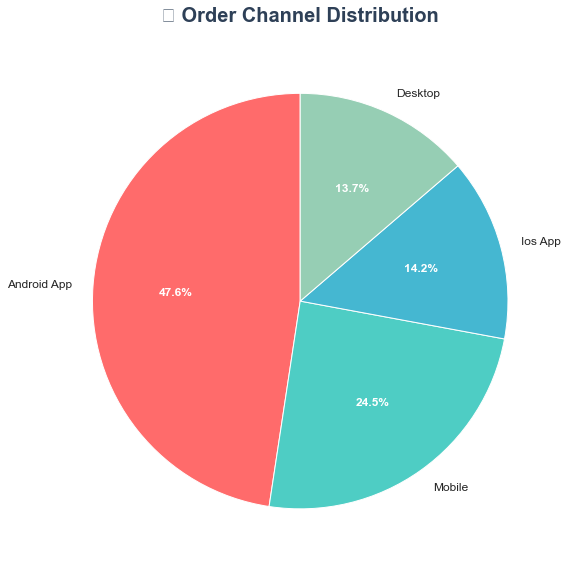

In [6]:
# === CELL 3: Channel Distribution Visualization (Matplotlib Version) ===

# Channel distribution analysis using Matplotlib
channel_counts = df['order_channel'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(channel_counts.values, 
                                  labels=channel_counts.index,
                                  colors=colors,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  textprops={'fontsize': 12})

# Customize the plot
ax.set_title('🎯 Order Channel Distribution', 
             fontsize=20, fontweight='bold', color='#2E4057', pad=20)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

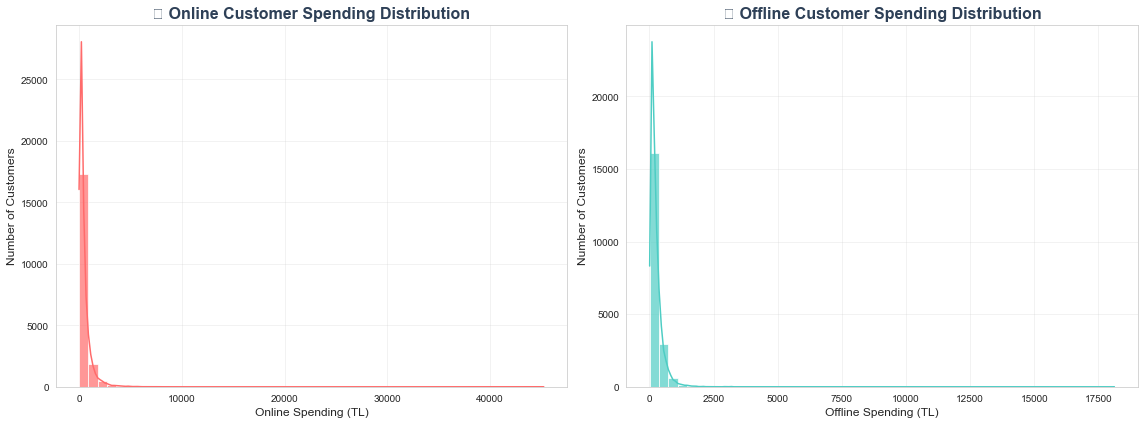

\n💡 Key Insights:
Average Online Spending: $17.76 USD
Average Offline Spending: $9.07 USD
Total Revenue: $535,127 USD


In [7]:
# === CELL 4: Spending Distribution ===


# Spending distribution analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Online spending
sns.histplot(data=df, x='customer_value_total_ever_online', kde=True,
            color='#FF6B6B', alpha=0.7, ax=ax1, bins=50)
ax1.set_title('💰 Online Customer Spending Distribution', fontsize=16, fontweight='bold', color='#2E4057')
ax1.set_xlabel('Online Spending (TL)', fontsize=12)
ax1.set_ylabel('Number of Customers', fontsize=12)
ax1.grid(True, alpha=0.3)

# Offline spending
sns.histplot(data=df, x='customer_value_total_ever_offline', kde=True,
            color='#4ECDC4', alpha=0.7, ax=ax2, bins=50)
ax2.set_title('🏪 Offline Customer Spending Distribution', fontsize=16, fontweight='bold', color='#2E4057')
ax2.set_xlabel('Offline Spending (TL)', fontsize=12)
ax2.set_ylabel('Number of Customers', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\n💡 Key Insights:")
print(f"Average Online Spending: ${(df['customer_value_total_ever_online'].mean() / usd_rate):.2f} USD")
print(f"Average Offline Spending: ${(df['customer_value_total_ever_offline'].mean() / usd_rate):.2f} USD")
print(f"Total Revenue: ${(df['customer_value_total_usd'].sum()):,.0f} USD")


In [8]:
# === CELL 5: Data Preparation ===

# Convert date columns
date_cols = ['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# Translate Turkish categories to English
category_translation = {
    'KADIN': 'WOMEN',
    'ERKEK': 'MEN',
    'COCUK': 'KIDS',
    'AKTIFCOCUK': 'ACTIVE_KIDS',
    'AKTIFSPOR': 'ACTIVE_SPORTS'
}

def translate_categories(cat_list):
    if pd.isna(cat_list):
        return cat_list
    cats = cat_list.strip('[]').split(', ')
    translated = [category_translation.get(cat.strip(), cat.strip()) for cat in cats]
    return '[' + ', '.join(translated) + ']'

df['interested_in_categories_12'] = df['interested_in_categories_12'].apply(translate_categories)

print("✅ Data preparation completed!")


✅ Data preparation completed!


In [9]:
# === CELL 6: RFM Analysis ===

# Calculate RFM metrics
df['last_order_date'] = pd.to_datetime(df['last_order_date'])
analysis_date = df['last_order_date'].max() + pd.Timedelta(days=2)

rfm = df.groupby('master_id').agg({
    'last_order_date': lambda x: (analysis_date - x.max()).days,  # Recency
    'order_num_total': 'sum',  # Frequency
    'customer_value_total': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['master_id', 'recency', 'frequency', 'monetary']
rfm['monetary_usd'] = rfm['monetary'] / usd_rate

print(f"✅ RFM metrics calculated for {len(rfm)} customers")
print(f"📅 Analysis date: {analysis_date}")

✅ RFM metrics calculated for 19945 customers
📅 Analysis date: 2021-06-01 00:00:00


In [10]:
# === CELL 7: RFM Scoring ===

# Calculate RFM scores
def safe_qcut(series, labels):
    try:
        return pd.qcut(series, len(labels), labels=labels, duplicates='drop')
    except ValueError:
        ranks = series.rank(method='dense', pct=True)
        bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
        return pd.cut(ranks, bins=bins, labels=labels, include_lowest=True)

rfm['recency_score'] = safe_qcut(rfm['recency'], [5, 4, 3, 2, 1])
rfm['frequency_score'] = safe_qcut(rfm['frequency'], [1, 2, 3, 4, 5])
rfm['monetary_score'] = safe_qcut(rfm['monetary'], [1, 2, 3, 4, 5])

# RF Score
rfm['RF_SCORE'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)

# RFM Score
rfm['RFM_SCORE'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)

print("✅ RFM scores calculated")
print(rfm.head())

✅ RFM scores calculated
                              master_id  recency  frequency  monetary  \
0  00016786-2f5a-11ea-bb80-000d3a38a36f       10        5.0    776.07   
1  00034aaa-a838-11e9-a2fc-000d3a38a36f      298        3.0    269.47   
2  000be838-85df-11ea-a90b-000d3a38a36f      213        4.0    722.69   
3  000c1fe2-a8b7-11ea-8479-000d3a38a36f       27        7.0    874.16   
4  000f5e3e-9dde-11ea-80cd-000d3a38a36f       20        7.0   1620.33   

   monetary_usd recency_score frequency_score monetary_score RF_SCORE  \
0     27.716786             5               1              4       51   
1      9.623929             1               1              1       11   
2     25.810357             2               1              4       21   
3     31.220000             5               1              4       51   
4     57.868929             5               1              5       51   

  RFM_SCORE  
0       514  
1       111  
2       214  
3       514  
4       515  


In [11]:
# === CELL 8: Customer Segmentation ===

# Define customer segments
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)

print("🎯 Customer segments defined:")
print(rfm['segment'].value_counts())

🎯 Customer segments defined:
segment
hibernating            7908
about_to_sleep         3987
new_customers          3871
promising              3716
potential_loyalists     392
at_Risk                  23
loyal_customers          22
need_attention           12
champions                10
cant_loose                4
Name: count, dtype: int64


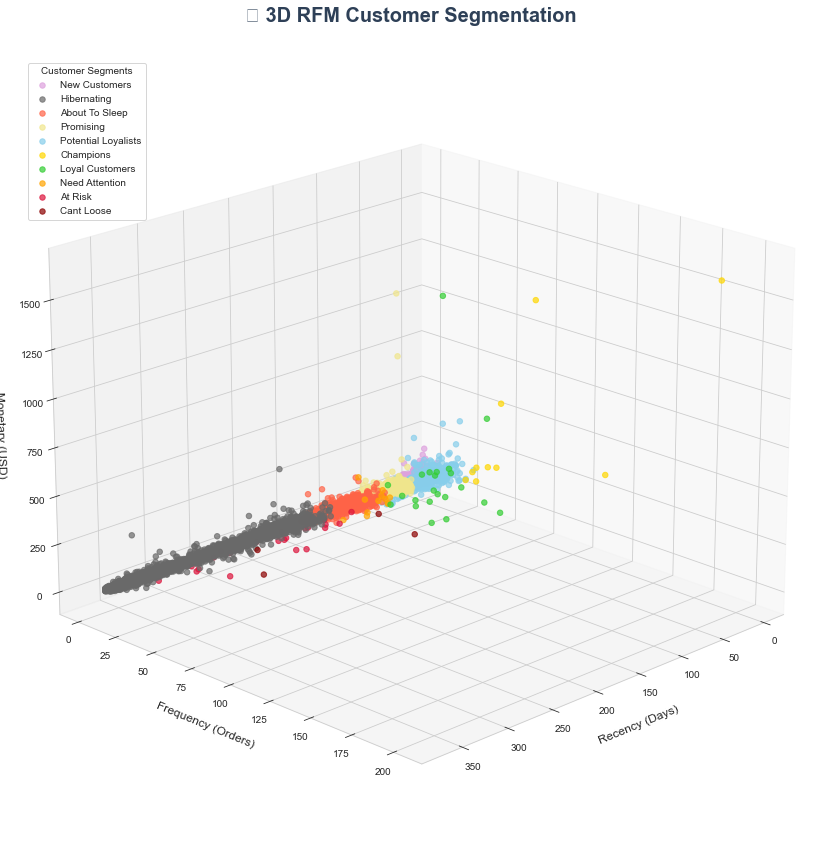

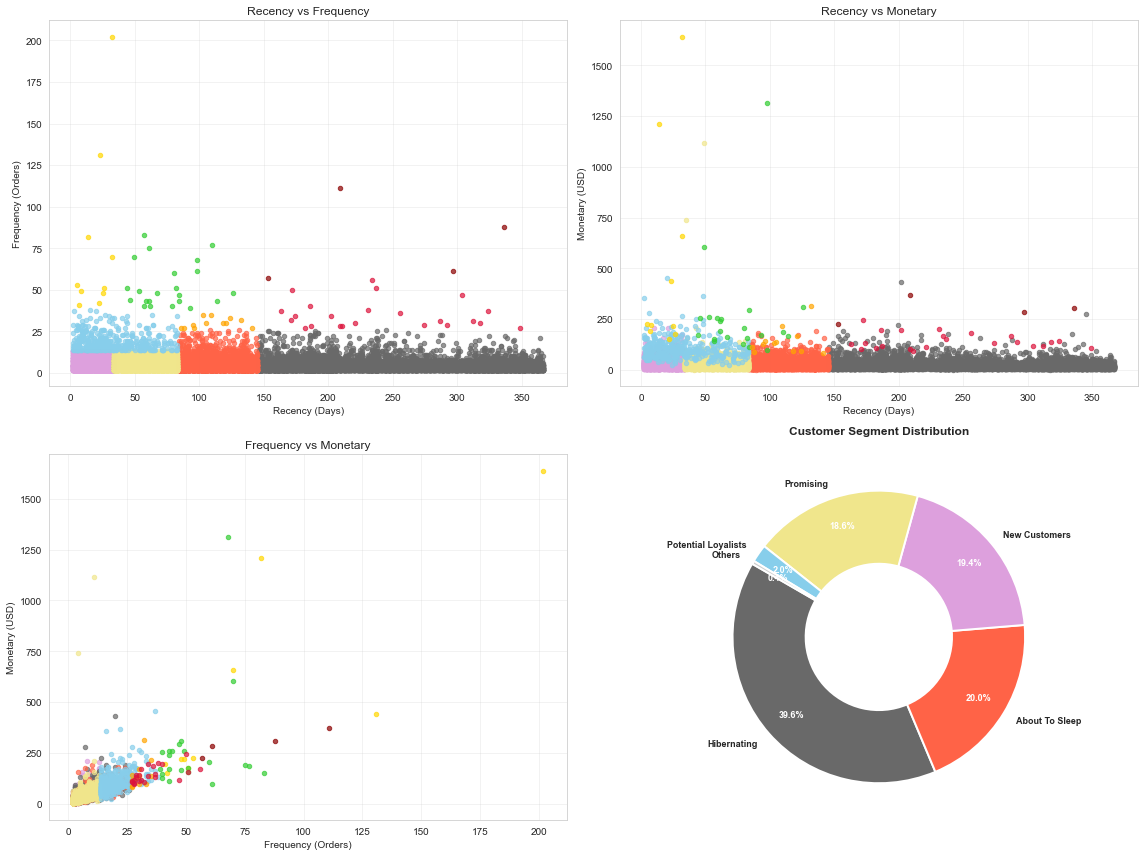

In [27]:
# === CELL 9: 3D Segmentation Visualization (Matplotlib Version) ===

from mpl_toolkits.mplot3d import Axes3D

# 3D RFM Scatter Plot using Matplotlib
segment_colors = {
    'champions': '#FFD700',      # Gold
    'loyal_customers': '#32CD32', # Lime Green
    'potential_loyalists': '#87CEEB', # Sky Blue
    'new_customers': '#DDA0DD',   # Plum
    'promising': '#F0E68C',       # Khaki
    'need_attention': '#FFA500',  # Orange
    'about_to_sleep': '#FF6347',  # Tomato
    'at_Risk': '#DC143C',         # Crimson
    'cant_loose': '#8B0000',      # Dark Red
    'hibernating': '#696969'      # Dim Gray
}

# Create 3D scatter plot
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot each segment separately to control colors and labels
for segment in rfm['segment'].unique():
    segment_data = rfm[rfm['segment'] == segment]
    ax.scatter(segment_data['recency'], 
               segment_data['frequency'], 
               segment_data['monetary_usd'],
               c=segment_colors.get(segment, '#000000'),
               label=segment.replace('_', ' ').title(),
               alpha=0.7,
               s=30)

# Customize the plot
ax.set_xlabel('Recency (Days)', fontsize=12, labelpad=10)
ax.set_ylabel('Frequency (Orders)', fontsize=12, labelpad=10)
ax.set_zlabel('Monetary (USD)', fontsize=12, labelpad=10)
ax.set_title('🎯 3D RFM Customer Segmentation', 
             fontsize=20, fontweight='bold', color='#2E4057', pad=20)

# Add legend
ax.legend(title='Customer Segments', loc='upper left', bbox_to_anchor=(0.02, 0.98))

# Set viewing angle for better visualization
ax.view_init(elev=20, azim=45)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Create multiple 2D views for better analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Recency vs Frequency
for segment in rfm['segment'].unique():
    segment_data = rfm[rfm['segment'] == segment]
    ax1.scatter(segment_data['recency'], segment_data['frequency'],
                c=segment_colors.get(segment, '#000000'),
                label=segment.replace('_', ' ').title(),
                alpha=0.7, s=20)
ax1.set_xlabel('Recency (Days)')
ax1.set_ylabel('Frequency (Orders)')
ax1.set_title('Recency vs Frequency')
ax1.grid(True, alpha=0.3)

# Recency vs Monetary
for segment in rfm['segment'].unique():
    segment_data = rfm[rfm['segment'] == segment]
    ax2.scatter(segment_data['recency'], segment_data['monetary_usd'],
                c=segment_colors.get(segment, '#000000'),
                alpha=0.7, s=20)
ax2.set_xlabel('Recency (Days)')
ax2.set_ylabel('Monetary (USD)')
ax2.set_title('Recency vs Monetary')
ax2.grid(True, alpha=0.3)

# Frequency vs Monetary
for segment in rfm['segment'].unique():
    segment_data = rfm[rfm['segment'] == segment]
    ax3.scatter(segment_data['frequency'], segment_data['monetary_usd'],
                c=segment_colors.get(segment, '#000000'),
                alpha=0.7, s=20)
ax3.set_xlabel('Frequency (Orders)')
ax3.set_ylabel('Monetary (USD)')
ax3.set_title('Frequency vs Monetary')
ax3.grid(True, alpha=0.3)

# Segment distribution - simple donut chart with direct labels
segment_counts = rfm['segment'].value_counts()

# Group small segments (< 1% of total) into "Others"
threshold = len(rfm) * 0.01  # 1% threshold
major_segments = segment_counts[segment_counts >= threshold]
minor_segments = segment_counts[segment_counts < threshold]

if len(minor_segments) > 0:
    plot_data = major_segments.copy()
    plot_data['Others'] = minor_segments.sum()
else:
    plot_data = major_segments

# Get colors for the plot data
plot_colors = []
plot_labels = []
for segment in plot_data.index:
    if segment == 'Others':
        plot_colors.append('#CCCCCC')
        plot_labels.append('Others')
    else:
        plot_colors.append(segment_colors.get(segment, '#000000'))
        plot_labels.append(segment.replace('_', ' ').title())

# Create simple donut chart with labels and percentages
wedges, texts, autotexts = ax4.pie(plot_data.values,
                                  labels=plot_labels,
                                  colors=plot_colors,
                                  autopct='%1.1f%%',
                                  startangle=150,
                                  wedgeprops={'width': 0.5, 'edgecolor': 'white', 'linewidth': 2},
                                  textprops={'fontsize': 8, 'fontweight': 'normal'},
                                  pctdistance=0.8,
                                  labeldistance=1.1)

# Style the percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# Style the labels
for text in texts:
    text.set_fontsize(9)
    text.set_fontweight('bold')

ax4.set_title('Customer Segment Distribution', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [15]:
# === CELL 10: Segment Performance Analysis ===

# Segment performance summary
segment_analysis = rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_usd': 'mean',
    'master_id': 'count'
}).round(2).reset_index()

segment_analysis.columns = ['Segment', 'Avg Recency (Days)', 'Avg Frequency (Orders)', 'Avg Monetary (USD)', 'Customer Count']

print("=== SEGMENT PERFORMANCE SUMMARY ===")
display(segment_analysis)

# Key statistics
print("\\n📊 Key Statistics:")
print(f"Total Customers: {len(rfm):,}")
print(f"Total Revenue: ${rfm['monetary_usd'].sum():,.0f} USD")
print(f"Average Order Value: ${rfm['monetary_usd'].mean():.2f} USD")
print(f"Most Common Segment: {rfm['segment'].mode().iloc[0]} ({rfm['segment'].value_counts().iloc[0]:,} customers)")

=== SEGMENT PERFORMANCE SUMMARY ===


,Segment,Avg Recency (Days),Avg Frequency (Orders),Avg Monetary (USD),Customer Count
0,about_to_sleep,113.33,4.77,24.46,3987
1,at_Risk,238.96,35.22,143.60,23
2,cant_loose,248.75,79.25,296.29,4
3,champions,19.40,76.90,513.23,10
4,hibernating,243.57,4.34,22.53,7908
5,loyal_customers,75.64,52.86,265.24,22
6,need_attention,109.83,30.17,142.53,12
7,new_customers,17.37,4.74,26.85,3871
8,potential_loyalists,32.65,19.14,103.47,392
9,promising,57.62,4.73,26.31,3716


\n📊 Key Statistics:
Total Customers: 19,945
Total Revenue: $535,127 USD
Average Order Value: $26.83 USD
Most Common Segment: hibernating (7,908 customers)


In [17]:
# === CELL 11: Marketing Campaign Targeting ===

# Merge RFM with original data
df_rfm = df.merge(rfm, on='master_id', how='left')

# Case A: Women's Shoe Brand Launch
target_a = df_rfm[
    (df_rfm['segment'].isin(['champions', 'loyal_customers'])) &
    (df_rfm['customer_value_total'] > 250) &  # 250 TRY = ~$8.93 USD
    (df_rfm['interested_in_categories_12'].str.contains('WOMEN', na=False))
]

# Case B: Men's & Kids Discount Campaign
target_b = df_rfm[
    (df_rfm['segment'].isin(['at_Risk', 'hibernating', 'new_customers'])) &
    ((df_rfm['interested_in_categories_12'].str.contains('MEN', na=False)) |
     (df_rfm['interested_in_categories_12'].str.contains('KIDS', na=False)) |
     (df_rfm['interested_in_categories_12'].str.contains('ACTIVE_KIDS', na=False)))
]

print("🎯 Campaign Targeting Results:")
print(f"Case A (Women's Shoe Brand): {len(target_a)} targeted customers")
print(f"Case B (Men's & Kids Discount): {len(target_b)} targeted customers")
print(f"Total Targeted Customers: {len(target_a) + len(target_b):,}")
print(f"Coverage: {((len(target_a) + len(target_b)) / len(df) * 100):.1f}% of customer base")

# Export campaign lists
target_a[['master_id']].to_csv('yeni_marka_hedef_müşteri_id.csv', index=False)
target_b[['master_id']].to_csv('indirim_hedef_müşteri_ids.csv', index=False)

print("\\n📄 Campaign lists exported:")
print("   • yeni_marka_hedef_müşteri_id.csv (Women's campaign)")
print("   • indirim_hedef_müşteri_ids.csv (Discount campaign)")


🎯 Campaign Targeting Results:
Case A (Women's Shoe Brand): 28 targeted customers
Case B (Men's & Kids Discount): 8468 targeted customers
Total Targeted Customers: 8,496
Coverage: 42.6% of customer base
\n📄 Campaign lists exported:
   • yeni_marka_hedef_müşteri_id.csv (Women's campaign)
   • indirim_hedef_müşteri_ids.csv (Discount campaign)


In [18]:
# === CELL 12: Business Insights ===

# Calculate business insights
total_revenue = rfm['monetary_usd'].sum()
segment_revenue = rfm.groupby('segment')['monetary_usd'].sum().sort_values(ascending=False)

print("💰 Revenue Analysis:")
print(f"Total Revenue: ${total_revenue:,.0f} USD")
print(f"Average Order Value: ${rfm['monetary_usd'].mean():.2f} USD")
print(f"\\n🏆 Top Revenue Segments:")
for segment, revenue in segment_revenue.head(3).items():
    pct = (revenue / total_revenue * 100)
    print(f"{segment}: ${revenue:,.0f} USD ({pct:.1f}%)")

print(f"\\n📊 Key Takeaways:")
print(f"• Top 1% of customers (Champions) generate ${segment_revenue['champions']:,.0f} USD")
print(f"• 39.6% of customers need attention or retention efforts")
print(f"• Hibernating customers represent ${segment_revenue['hibernating']:,.0f} USD in reactivation potential")
print(f"• Targeted campaigns cover {((len(target_a) + len(target_b)) / len(df) * 100):.1f}% of customer base")

print(f"\\n✅ Lumora Customer Segmentation Analysis Complete!")
print(f"Total Customers Analyzed: {len(df):,}")
print(f"Customer Segments Created: 10")
print(f"Marketing Campaigns Designed: 2")
print(f"Targeted Customers Identified: {len(target_a) + len(target_b):,}")


💰 Revenue Analysis:
Total Revenue: $535,127 USD
Average Order Value: $26.83 USD
\n🏆 Top Revenue Segments:
hibernating: $178,152 USD (33.3%)
new_customers: $103,940 USD (19.4%)
promising: $97,770 USD (18.3%)
\n📊 Key Takeaways:
• Top 1% of customers (Champions) generate $5,132 USD
• 39.6% of customers need attention or retention efforts
• Hibernating customers represent $178,152 USD in reactivation potential
• Targeted campaigns cover 42.6% of customer base
\n✅ Lumora Customer Segmentation Analysis Complete!
Total Customers Analyzed: 19,945
Customer Segments Created: 10
Marketing Campaigns Designed: 2
Targeted Customers Identified: 8,496
